In [241]:
#Inspired by https://imgur.com/6sPyczX
#Replicated image then extended to other years, colored by playoffs
#Added line of best fit
#Checked Pearson's Correlation Coefficient
#Will plot all years together

In [351]:
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import csv
import matplotlib
import matplotlib.pyplot as plt
import urllib3
import time

In [243]:
def get_response(url):
    print(f"Requesting \'{url}\'")
    try:
        r = requests.get(url)
        text = r.text
        text= text.replace("<!--", "")
        text= text.replace("-->", "")
        return BeautifulSoup(text, 'lxml')
    except requests.exceptions.RequestException as e:
        print(e)
    return None

In [244]:
teams = {'Atlanta Hawks':'ATL',
'Boston Celtics':'BOS',
'Brooklyn Nets':'BRK',
'Charlotte Bobcats':'CHA',
'Charlotte Hornets':'CHO',
'Chicago Bulls':'CHI',
'Cleveland Cavaliers':'CLE',
'Dallas Mavericks':'DAL',
'Denver Nuggets':'DEN',
'Detroit Pistons':'DET',
'Golden State Warriors':'GSW',
'Houston Rockets':'HOU',
'Indiana Pacers':'IND',
'Los Angeles Clippers':'LAC',
'Los Angeles Lakers':'LAL',
'Memphis Grizzlies':'MEM',
'Miami Heat':'MIA',
'Milwaukee Bucks':'MIL',
'Minnesota Timberwolves':'MIN',
'New Jersey Nets':'NJN',
'New Orleans Hornets':'NOH',
'New Orleans Pelicans':'NOP',
'New OrleansOklahoma City Hornets':'NOK',
'New York Knicks':'NYK',
'Oklahoma City Thunder':'OKC',
'Orlando Magic':'ORL',
'Philadelphia 76ers':'PHI',
'Phoenix Suns':'PHO',
'Portland Trail Blazers':'POR',
'Sacramento Kings':'SAC',
'San Antonio Spurs':'SAS',
'Seattle SuperSonics':'SEA',
'Toronto Raptors':'TOR',
'Utah Jazz':'UTA',
'Vancouver Grizzlies':'VAN',
'Washington Bullets':'WSB',
'Washington Wizards':'WAS'}


In [245]:
#for year in range(1988,2020):
def get_ages(year):
    
    #Check if we have the csv already:
    pd.set_option('precision', 3)
    directory = os.path.join(os.getcwd(),'Ages')
    ages = pd.DataFrame()
    for filename in os.listdir(directory):
        if re.match(f"ages_{year}.csv", filename): #Scraped with "get_year(), above"
            df=pd.read_csv(os.path.join(directory,filename),header=0)
            return df.drop(df.columns[0],axis=1)
        else:
            continue
    
    team_col=[]
    age_mp_col=[]
    for team in teams:
        data = []
        url = f"https://www.basketball-reference.com/teams/{teams[team]}/{year}.html"
        soup = get_response(url)
        table = soup.find('table', attrs={'id':"totals"})
        if table == None:
            print(teams[team],"not in ",year)
            continue
        table_head = table.find('thead')
        hrow = table_head.find('tr')
        hcols = hrow.find_all('th')
        hcols = [ele.text.strip() for ele in hcols]
        data.append([ele for ele in hcols if ele])
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            cols = [ele.text.strip() for ele in row.find_all('th')]
            if cols[0] == 'Rk':
                continue
            cols += [ele.text.strip() for ele in row.find_all('td')]
            data.append([ele for ele in cols])    
        df=pd.DataFrame(data)
        col=df.iloc[0][:-1]
        df=df.set_index(0)
        df.columns = col
        df=df.drop("Rk").rename(columns={"Rk":"player"}).set_index("player")
        df["Age"]=df["Age"].astype(int)
        df["MP"]=df["MP"].astype(int)
        df["AgeMP"]=df['Age']*df["MP"]
        age_mp_col.append(sum(df["AgeMP"])/sum(df["MP"]))
        team_col.append(teams[team])
    age_df = pd.DataFrame([team_col, age_mp_col]).T
    age_df.columns = ["Tm","ages"]

    pd.set_option('precision', 3)
    directory = os.path.join(os.getcwd(),'scrapedata')
    east, west = pd.DataFrame(), pd.DataFrame()
    for filename in os.listdir(directory):
        if re.match(f"[a-z]+s_standings_E_{year}.csv", filename): #Scraped with "second_player_stats_scrape.ipynb"
            east = pd.read_csv(os.path.join(directory,filename))
        elif re.match(f"[a-z]+s_standings_W_{year}.csv", filename):
            west = pd.read_csv(os.path.join(directory,filename))

    east = east.rename(columns = {'Eastern Conference':'Tm'}).sort_values('W/L%', ascending=False).reset_index(drop=True)
    west = west.rename(columns = {'Western Conference':'Tm'}).sort_values('W/L%', ascending=False).reset_index(drop=True)
    standings = pd.concat([east, west]).dropna()
    standings = standings.loc[:,['Tm','W','L','W/L%']]
    standings['playoffs'] = standings['Tm'].str.contains('\*').astype(int)
    standings['seed'] = standings.index + 1
    if year == 2019:
        standings['playoffs'][standings.index < 8] = 1   # assume playoffs for top 8 teams in each conference
    standings['games'] = standings['W'] + standings ['L']
    standings['Tm'] = standings['Tm'].str.replace('[^\w\s]+','').str.replace('\d+\s*$','').str.strip()
    standings = standings.replace({'Tm':teams}, regex=True)
    if year < 2003:   # if year is < 2003 replace CHA with CHH. ugly but it works!
        standings['Tm'].replace('CHO','CHH', inplace=True)
    standings = standings.drop(['W','L'], axis=1)

    df_merge = pd.merge(age_df, standings, on='Tm', how='left')
    df_merge['ages'] = df_merge['ages'].astype(float)
    df_merge['W/L%'] = df_merge['W/L%'].astype(float)
        
    # output to csv
    outdir = os.path.join(os.getcwd(),'Ages')
    if not os.path.exists(outdir):
        print(f"Creating directory \'{outdir}\'")
        os.makedirs(outdir)
    df_merge.to_csv(outdir + f'/ages_{year}.csv', float_format='%.3f')
    
    return df_merge

#get_ages(2019)


In [269]:
#Use this to plot Ages (weighted by Minutes played) vs Win Lose Percentage for all teams in any single season
def plot_ages(year):
    df_merge=get_ages(year)
    correlation = np.corrcoef(list(df_merge["ages"]), list(df_merge["W/L%"]))[0,1]                   
    plt.scatter(df_merge["ages"],df_merge["W/L%"],c=df_merge["playoffs"])
    for i in range(len(df_merge)):
        plt.annotate(df_merge["Tm"][i],(df_merge["ages"][i],df_merge["W/L%"][i]),xytext=(df_merge["ages"][i]+.05,df_merge["W/L%"][i]+.01))
    plt.plot(np.unique(df_merge["ages"]), np.poly1d(np.polyfit(df_merge["ages"], df_merge["W/L%"], 1))(np.unique(df_merge["ages"])))
    plt.xlabel("Age")
    plt.ylabel("W/L %")
    plt.title("Age vs W/L% in "+str(year)+", correlation = "+(str(round(correlation,3))))
    plt.show()

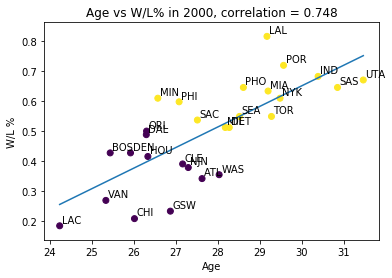

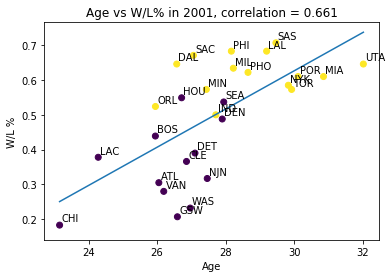

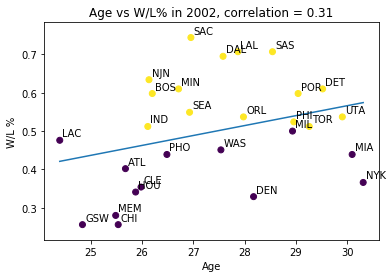

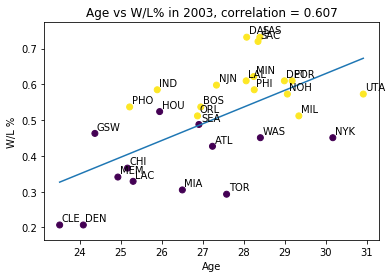

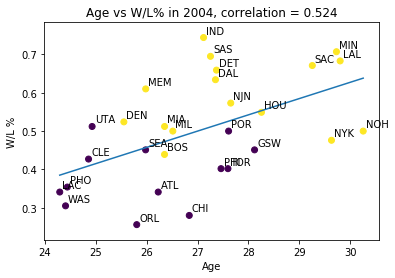

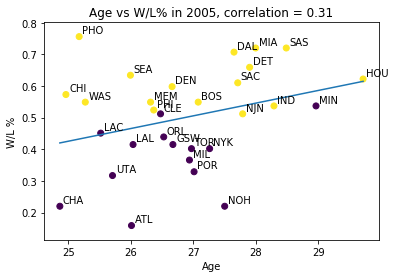

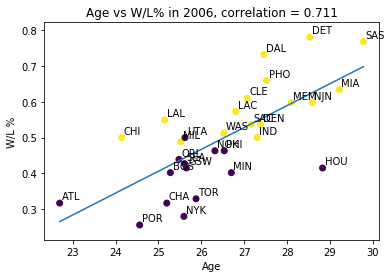

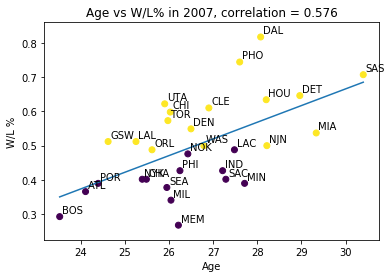

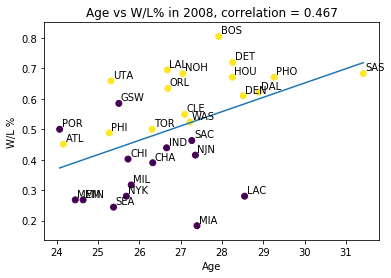

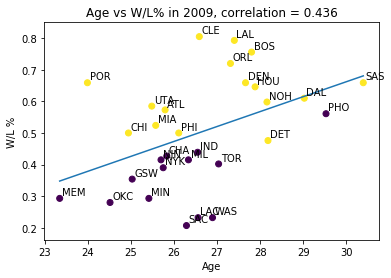

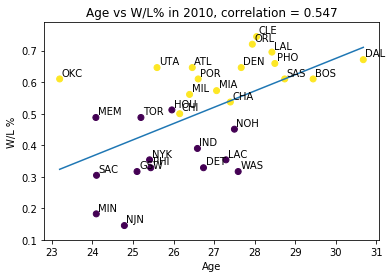

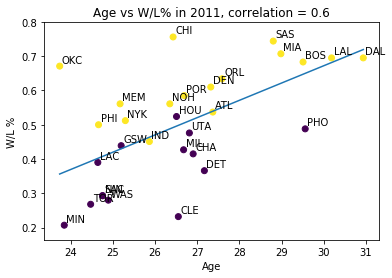

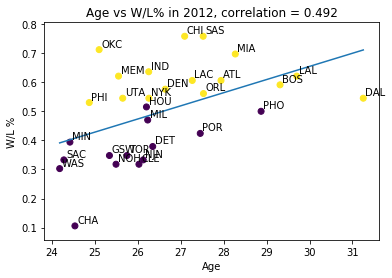

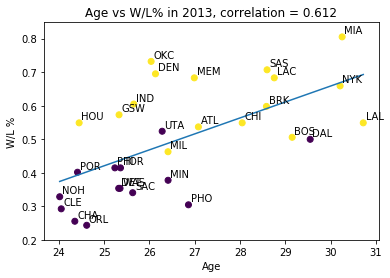

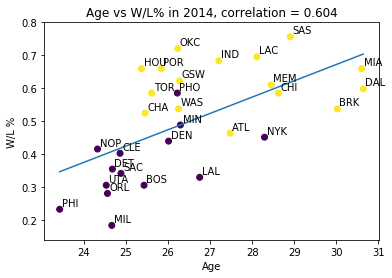

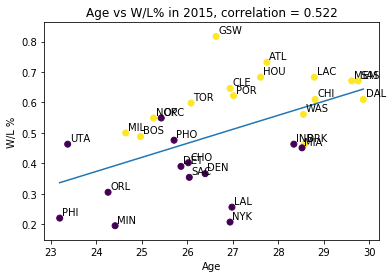

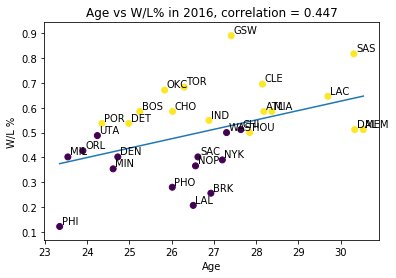

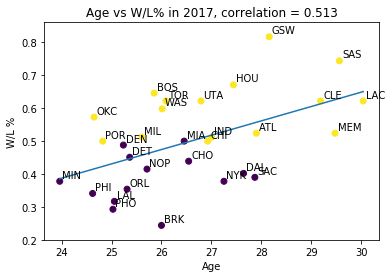

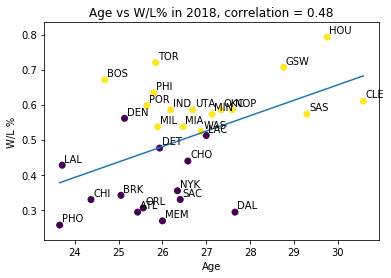

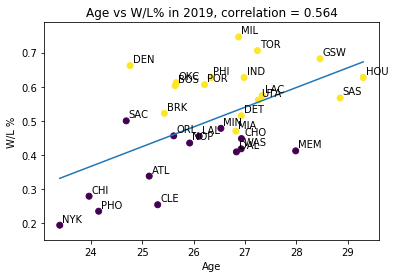

In [270]:
for year in range(2000,2020):
    plot_ages(year)

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


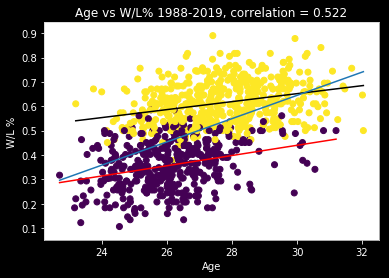

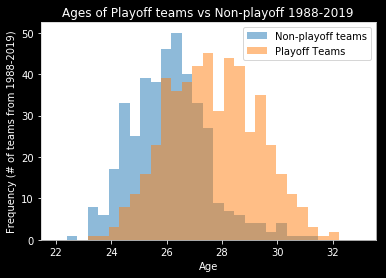

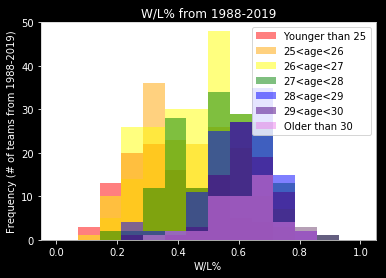

In [428]:
#Use this to plot ages (weighted by Minutes played) vs Win Lose Percentage for all teams in any range of seasons
def plot_age_range(start_year,end_year):
    df=pd.DataFrame()
    for year in range(start_year, end_year+1):
        df_merge=get_ages(year)
        df_merge['year']=year
        if df.empty:
            df=df_merge
        else:
            df=pd.concat([df,df_merge])
    df["W/L%"]=df["W/L%"].astype(float)
    df["ages"]=df["ages"].astype(float)
    
    f=plt.figure(1)
    correlation = np.corrcoef(list(df["ages"]), list(df["W/L%"]))[0,1]      
    plt.scatter(df["ages"],df["W/L%"],c=df["playoffs"])

    #Line of best fit for just playoff teams
    plt.plot(np.unique(df[df['playoffs']==1]["ages"]), np.poly1d(np.polyfit(df[df['playoffs']==1]["ages"], df[df['playoffs']==1]["W/L%"], 1))(np.unique(df[df['playoffs']==1]["ages"])),color='black')
    
    #Line of best fit for just non-playoff teams
    plt.plot(np.unique(df[df['playoffs']==0]["ages"]), np.poly1d(np.polyfit(df[df['playoffs']==0]["ages"], df[df['playoffs']==0]["W/L%"], 1))(np.unique(df[df['playoffs']==0]["ages"])),color='red')
    
    #Line of best fit for all teams
    plt.plot(np.unique(df["ages"]), np.poly1d(np.polyfit(df["ages"], df["W/L%"], 1))(np.unique(df["ages"])))
    
    plt.xlabel("Age")
    plt.ylabel("W/L %")
    plt.title("Age vs W/L% "+ str(start_year)+"-"+str(end_year)+", correlation = "+(str(round(correlation,3))),color='w')
    f.show()

    g = plt.figure(2)
    
    x = df[df['playoffs']==0]["ages"]
    y = df[df['playoffs']==1]["ages"]
    bins = numpy.linspace(22, 33,30)
    plt.hist(x, bins, alpha=0.5, label='Non-playoff teams')
    plt.hist(y, bins, alpha=0.5, label='Playoff Teams')
    plt.legend(loc='upper right')
    plt.xlabel("Age")
    plt.ylabel("Frequency (# of teams from " +str(start_year)+"-"+str(end_year)+")")
    plt.title("Ages of Playoff teams vs Non-playoff " +str(start_year)+"-"+str(end_year)+"",color='w')
    g.show()
    
    h = plt.figure(3)
    
    x = df[(df['ages']<25)]["W/L%"]
    y1 = df[(df['ages']>=25)&(df['ages']<26)]["W/L%"]
    y2 = df[(df['ages']>=26)&(df['ages']<27)]["W/L%"]
    y3 = df[(df['ages']>=27)&(df['ages']<28)]["W/L%"]
    y4 = df[(df['ages']>=28)&(df['ages']<29)]["W/L%"]
    y5 = df[(df['ages']>=29)&(df['ages']<30)]["W/L%"]
    y6 = df[df['ages']>=30]["W/L%"]
    
    m,m1,m2,m3,m4,m5,m6 = x.mean(),y1.mean(),y2.mean(),y3.mean(),y4.mean(),y5.mean(),y6.mean()
    
    bins = numpy.linspace(0, 1,15)
    plt.ylim(0,50)
    
    plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})
    
    plt.hist(x, bins, alpha=0.5, label='Younger than 25',color='red')
#     plt.annotate("mean W/L%: "+str(round(m,3)*100)+"%",(0,45))
    
    plt.hist(y1, bins, alpha=0.5, label='25<age<26',color='orange')
#     plt.annotate("mean W/L%: "+str(round(m1,3)*100)+"%",(0,45))
    
    plt.hist(y2, bins, alpha=0.5, label='26<age<27',color='yellow')
#     plt.annotate("mean W/L%: "+str(round(m2,3)*100)+"%",(0,45))
    
    plt.hist(y3, bins, alpha=0.5, label='27<age<28',color='green')
#     plt.annotate("mean W/L%: "+str(round(m3,3)*100)+"%",(0,45))
    
    plt.hist(y4, bins, alpha=0.5, label='28<age<29',color='blue')
#     plt.annotate("mean W/L%: "+str(round(m4*100,1))+"%",(0,45))
    
    plt.hist(y5, bins, alpha=0.5, label='29<age<30',color='indigo')
#     plt.annotate("mean W/L%: "+str(round(m5,3)*100)+"%",(0,45))
    
    plt.hist(y6, bins, alpha=0.5, label='Older than 30',color='violet')
#     plt.annotate("mean W/L%: "+str(round(m6,3)*100)+"%",(0,45))
    
    plt.legend(loc='upper right')
    plt.xlabel("W/L%")
    plt.ylabel("Frequency (# of teams from " +str(start_year)+"-"+str(end_year)+")")
    plt.title("W/L% from " +str(start_year)+"-"+str(end_year)+"",color='w')

    h.show()
    
    
plot_age_range(1988,2019)